<a id = "objetivos"></a>
# Objetivos del notebook


Utilizando el dataset obtenido hasta ahora vamos a construir una segmentacion  de los productos (items) basada en el algoritmo KMeans.


1. **Construir variables de negocio (pensadas para nuestra segmentación)**


2. **Implementar nuestros propios Transformers** que se puedan usar dentro de los Pipelines (por ejemplo para eliminar los outliers).


3. Usar el diagrama del codo para determinar la cantidad **"óptima"** de centroides para el modelo de KMeans y definir los diferentes clusters.


4. **Resumir la información de nuestros clústers en un formato más amigable** usando Pandas (fichas de productos).

<a id = "import_modules"></a>
# Importación de las principales librerías

En esta sección del kernel vamos a cargar las principales librerías que vamos a usar en nuestro notebook durante la implementación del algoritmo **KMeans.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
import datetime


# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# python core library for machine learning and data science
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

RANDOM_STATE = 175

In [ ]:
import sklearn
print(sklearn.__version__)

1.0.2


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/MASTER EN DATA SCIENCE/Capstone/data_dsmarket/GrupoRetail_1/Proceso Total/BBDD output/bbdd_clustering_v1.xlsx")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3049 entries, 0 to 3048
Data columns (total 89 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 3049 non-null   int64  
 1   item                       3049 non-null   object 
 2   sales_2011                 3049 non-null   float64
 3   sales_2012                 3049 non-null   float64
 4   sales_2013                 3049 non-null   float64
 5   sales_2014                 3049 non-null   float64
 6   sales_2015                 3049 non-null   float64
 7   sales_2016                 3049 non-null   float64
 8   sales                      3049 non-null   float64
 9   mean_pvp                   3049 non-null   float64
 10  weekend_sale_total %       3049 non-null   float64
 11  summer_sales_total %       3049 non-null   float64
 12  christmas_sales_total %    3049 non-null   float64
 13  2016_vs_2015               3043 non-null   float

In [ ]:
del(df['Unnamed: 0'])
df.set_index("item", inplace = True)

In [ ]:
encoder = LabelEncoder()
df["category_id"] = encoder.fit_transform(df["category"])
df.drop("category", inplace = True, axis = 1)

In [ ]:
df['category_id'].value_counts()

2    1437
1    1047
0     565
Name: category_id, dtype: int64

<a id = "df1"></a>
# EDA customers df
[Volver al índice](#table_of_contents)

EDA rápido sobre el **dataset de clientes.**

In [ ]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose))
    total_nulos = df.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos, correspondientes a ceros en ventas por año o por tienda")

In [ ]:
report_df(df)
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3049 entries, ACCESORIES_1_001 to SUPERMARKET_3_827
Data columns (total 87 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sales_2011                 3049 non-null   float64
 1   sales_2012                 3049 non-null   float64
 2   sales_2013                 3049 non-null   float64
 3   sales_2014                 3049 non-null   float64
 4   sales_2015                 3049 non-null   float64
 5   sales_2016                 3049 non-null   float64
 6   sales                      3049 non-null   float64
 7   mean_pvp                   3049 non-null   float64
 8   weekend_sale_total %       3049 non-null   float64
 9   summer_sales_total %       3049 non-null   float64
 10  christmas_sales_total %    3049 non-null   float64
 11  2016_vs_2015               3043 non-null   float64
 12  2015_vs_2014               2996 non-null   float64
 13  2014_vs_2013             

,sales_2011,sales_2012,sales_2013,sales_2014,sales_2015,sales_2016,sales,mean_pvp,weekend_sale_total %,summer_sales_total %,...,BOS_2_2016,BOS_3_2016,NYC_1_2016,NYC_2_2016,NYC_3_2016,NYC_4_2016,PHI_1_2016,PHI_2_2016,PHI_3_2016,category_id
item,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,0.00,0.00,6451.46,11684.98,14752.31,3021.34,35910.09,11.005238,0.030604,0.024144,...,164.85,219.80,551.58,441.52,628.83,430.21,220.60,89.20,87.92,0
ACCESORIES_1_002,3938.88,4757.28,4575.14,4476.11,4488.00,633.60,22869.01,5.279088,0.066334,0.054834,...,36.96,36.96,47.52,21.12,15.84,36.96,221.76,121.44,79.20,0
ACCESORIES_1_003,0.00,0.00,0.00,1239.94,2709.70,533.25,4482.89,3.935812,0.094582,0.070267,...,11.85,51.35,94.80,86.90,63.20,59.25,71.10,47.40,11.85,0
ACCESORIES_1_004,31442.90,32909.78,42745.76,43819.34,34700.08,4905.15,190523.01,6.008105,0.059337,0.047852,...,407.22,222.12,598.49,820.61,1776.96,234.46,92.55,154.25,308.50,0
ACCESORIES_1_005,10011.21,8138.21,8264.97,7131.76,9948.79,1900.43,45395.37,3.810894,0.093071,0.079942,...,87.12,98.01,245.12,283.42,463.43,237.46,153.20,122.56,61.28,0


In [ ]:
df["2016_vs_2015"] = df.groupby("item")["2016_vs_2015"].apply(lambda series: series.backfill().ffill())
df["2015_vs_2014"] = df.groupby("item")["2015_vs_2014"].apply(lambda series: series.backfill().ffill())
df["2014_vs_2013"] = df.groupby("item")["2014_vs_2013"].apply(lambda series: series.backfill().ffill())
df["2012_vs_2011"] = df.groupby("item")["2012_vs_2011"].apply(lambda series: series.backfill().ffill())
df["weekend_sale_total %"] = df.groupby("item")["weekend_sale_total %"].apply(lambda series: series.backfill().ffill())
df["summer_sales_total %"] = df.groupby("item")["summer_sales_total %"].apply(lambda series: series.backfill().ffill())
df["christmas_sales_total %"] = df.groupby("item")["christmas_sales_total %"].apply(lambda series: series.backfill().ffill())
df["mean_discount"] = df.groupby("item")["mean_discount"].apply(lambda series: series.backfill().ffill())

In [ ]:
df.fillna(0, inplace=True)

In [ ]:
report_df(df)

<class 'pandas.core.frame.DataFrame'>
Index: 3049 entries, ACCESORIES_1_001 to SUPERMARKET_3_827
Data columns (total 87 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sales_2011                 3049 non-null   float64
 1   sales_2012                 3049 non-null   float64
 2   sales_2013                 3049 non-null   float64
 3   sales_2014                 3049 non-null   float64
 4   sales_2015                 3049 non-null   float64
 5   sales_2016                 3049 non-null   float64
 6   sales                      3049 non-null   float64
 7   mean_pvp                   3049 non-null   float64
 8   weekend_sale_total %       3049 non-null   float64
 9   summer_sales_total %       3049 non-null   float64
 10  christmas_sales_total %    3049 non-null   float64
 11  2016_vs_2015               3049 non-null   float64
 12  2015_vs_2014               3049 non-null   float64
 13  2014_vs_2013             

In [ ]:
df[df.duplicated(keep=False)]

,sales_2011,sales_2012,sales_2013,sales_2014,sales_2015,sales_2016,sales,mean_pvp,weekend_sale_total %,summer_sales_total %,...,BOS_2_2016,BOS_3_2016,NYC_1_2016,NYC_2_2016,NYC_3_2016,NYC_4_2016,PHI_1_2016,PHI_2_2016,PHI_3_2016,category_id
item,,,,,,,,,,,,,,,,,,,,,


<a id = "skpipeline"></a>
# Creación de nuestro Pipeline
[Volver al índice](#table_of_contents)

Llegamos a este punto tenemos que hacer las últimas transformaciones de nuestro dataframe así como crear las últimas variables para nuestra segmentación.

Una forma de hacerlo es utilizar el pipeline de sklearn para automatizar todos estos pasos. Para ello tendremos que implementar nuestros propios ***"Transformers."***

Un ***Transformer*** en sklearn no es más una clase que tiene implementado el método **fit, transform  y fit_transform** (que puede realizar cualquier transformación sobre el dataset que le pasas).

No obstante, en la práctica sólo vamos a implementar un método, el **transform**, porque el **fit** (cuando heredamos de ***TransformerMixin***) sólo tiene que devolver el ***self*** y el **fit_transform** se va a crear sólo.

Heredamos también del ***BaseEstimator*** para tener acceso al método de ***get_params() y set_params()*** aunque en la práctica no lo vamos a usar.

In [ ]:
class ArrayToDataFrame(BaseEstimator, TransformerMixin):
    '''
    Clase que transforma un array en un DataFrame.
    Necesita como parámetros el nombre de las columnas y el índice.
    '''
    
    def __init__(self, columns, index = None):
        self.columns = columns
        self.index = index
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        if self.index != None:
            df = pd.DataFrame(X, columns = self.columns, index = self.index)
            
        else:
            df = pd.DataFrame(X, columns = self.columns)
            
        return df

Los ***outliers*** pueden distorsionar mucho nuestro KMeans, pudiendo llegar a crear grupos de 1 sólo cliente.

Para que esto no ocurra, tenemos que eliminar cualquier posible ***outlier.*** y luego estandarizar o normalizar nuestros datos.

A continuación vamos a implementar nuestro propio ***OutlierFilter***

In [ ]:
class OutlierFilter(BaseEstimator, TransformerMixin):
    '''
    Clase que filtra los outliers utilizando np.quantile()
    Los cuantiles a filtrar así como las columnas a filtrar son los parámetros de la clase.
    '''
    
    def __init__(self, q, col_to_filter):
        self.q = q
        self.col_to_filter = col_to_filter
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        '''
        El método considera outlier a aquel cliente que es outlier en todas las columnas que le pasas.
        Es decir: si tiene que filtrar importe y número de pedidos, sólo va a eliminar aquellos clientes
        que son outlier tanto en importe como número de pedidos. Si eres outlier en importe pero no en pedido
        no se te va a filtrar del dataset.
        '''
        
        # lista vacía
        criteria_list = []
        
        # agregamos a la lista los clientes que son outliers
        for col in self.col_to_filter:
            criteria = X[col] < np.quantile(X[col], q = self.q)
            criteria_list.append(criteria)
            
        # si hay más de 1 columna
        if len(self.col_to_filter) > 1:
            
            # creamos el criterio global: es decir outlier en todas las columnas
            global_criteria = criteria_list[0]
            
            for criteria in criteria_list[1:]:
                global_criteria = global_criteria & criteria
                
        else:
            global_criteria = criteria_list[0]
            
        # filtramos nuestra dataframe
        X = X[global_criteria]
        
        # guardamos el índice como parámetro de la clase porque en caso contrario lo perderíamos.
        self.index = X.index
        
        return X

In [ ]:
df_final = df.copy(deep = True)

In [ ]:
df_final.shape

(3049, 87)

In [ ]:
columns = list(df_final.columns)
index = list(df_final.index)

In [ ]:
df_final

,sales_2011,sales_2012,sales_2013,sales_2014,sales_2015,sales_2016,sales,mean_pvp,weekend_sale_total %,summer_sales_total %,...,BOS_2_2016,BOS_3_2016,NYC_1_2016,NYC_2_2016,NYC_3_2016,NYC_4_2016,PHI_1_2016,PHI_2_2016,PHI_3_2016,category_id
item,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,0.00,0.00,6451.46,11684.98,14752.31,3021.34,35910.09,11.005238,0.030604,0.024144,...,164.85,219.80,551.58,441.52,628.83,430.21,220.60,89.20,87.92,0
ACCESORIES_1_002,3938.88,4757.28,4575.14,4476.11,4488.00,633.60,22869.01,5.279088,0.066334,0.054834,...,36.96,36.96,47.52,21.12,15.84,36.96,221.76,121.44,79.20,0
ACCESORIES_1_003,0.00,0.00,0.00,1239.94,2709.70,533.25,4482.89,3.935812,0.094582,0.070267,...,11.85,51.35,94.80,86.90,63.20,59.25,71.10,47.40,11.85,0
ACCESORIES_1_004,31442.90,32909.78,42745.76,43819.34,34700.08,4905.15,190523.01,6.008105,0.059337,0.047852,...,407.22,222.12,598.49,820.61,1776.96,234.46,92.55,154.25,308.50,0
ACCESORIES_1_005,10011.21,8138.21,8264.97,7131.76,9948.79,1900.43,45395.37,3.810894,0.093071,0.079942,...,87.12,98.01,245.12,283.42,463.43,237.46,153.20,122.56,61.28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_823,11518.08,5626.44,3885.19,5473.80,13051.48,877.10,40432.09,3.311120,0.104076,0.085526,...,25.06,57.28,78.76,125.30,361.58,125.30,32.22,17.90,28.64,2
SUPERMARKET_3_824,5950.36,6015.48,3879.82,4568.44,821.14,416.52,21651.76,3.059455,0.105950,0.112739,...,50.66,15.14,71.52,71.52,62.58,29.80,30.04,53.64,25.66,2
SUPERMARKET_3_825,12015.94,4159.35,9822.90,11610.62,11448.10,2571.64,51628.55,4.864652,0.070019,0.065913,...,215.10,262.90,258.12,143.40,549.70,133.84,291.58,396.74,224.66,2


Llegamos a este punto tenemos todo listo para construir nuestro pipeline.

Los pasos que va a realizar son:

1. Usar el ***KNNImputer***, que se basa en la misma noción de **métricas de distancia** para imputar los valores nulos en función de los cliente más similares.

2. Dado que en el primer paso, nos devuelve un array, usamos nuestro propio ***Transformer*** para convertir a DataFrame.

3. Creamos variables a nivel de cliente. **POR TANTO VAMOS NUESTRO DATAFRAME DE SALIDA SERÁ MÁS PEQUEÑO.**

4. Filtramos los outliers con nuestro propio ***Transformer***. **POR TANTO VAMOS NUESTRO DATAFRAME DE SALIDA SERÁ MÁS PEQUEÑO.**

5. Estandarizamos los valores, usando ***StandardScaler***.

6. Hacemos un fit con KMeans para calcular la **inertia** de los grupos (la dispersión de los datos al centroide).

Técnica del ***Elbow Curve***: todo esto lo hacemos en una loop porque queremos ver cuando hay un cambio brusco en la inertia y por tanto, **aumentar más el número de centroides no nos sale a cuenta porque la ganacia marginal es muy pequeña.**

In [ ]:
CALCULATE_ELBOW = True

In [ ]:
# separamos el pipeline del a loop, para no tener que volver a hacer los primeros pasos para cada k de la loop
pipe = Pipeline(steps = [
     ("Imputer", KNNImputer()),
     ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
     ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ['sales', 'mean_pvp', 'summer_sales_total %', 'weekend_sale_total %', 'christmas_sales_total %', 'exhibition_time', '2016_vs_2015', '2015_vs_2014','2014_vs_2013', 'mean_discount'])),
     ("StandardScaler", StandardScaler())
])

In [ ]:
 df_scaled_transformed_no_outliers = pipe.fit_transform(df_final)

In [ ]:
 if CALCULATE_ELBOW:
    st = time.time()

    sse = {}

    for k in range(2, 15):

        print(f"Fitting pipe with {k} clusters")

        clustering_model = KMeans(n_clusters = k)

        clustering_model.fit(df_scaled_transformed_no_outliers)

        sse[k] = clustering_model.inertia_

    et = time.time()
print("Elbow curve took {} seconds.".format(round((et - st)), 2))

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters
Elbow curve took 21 seconds.


In [ ]:
sse

{2: 140662.47027036984,
 3: 124845.3845200692,
 4: 117777.03269568474,
 5: 113399.15658948448,
 6: 109603.30712060365,
 7: 106083.4178726555,
 8: 103290.33376915674,
 9: 100430.17860592135,
 10: 98130.47446408082,
 11: 96219.4579492456,
 12: 94020.89576081229,
 13: 93204.76579378078,
 14: 91323.63845148898}

<a id = "elbow_curve"></a>
# Elbow curve
[Volver al índice](#table_of_contents)

En esta sección vamos a visualizar nuestro ***Elbow Curve*** y buscaremos el punto de inflexión que será nuestro número de centroides.

In [ ]:
df_final.isnull().sum()

sales_2011     0
sales_2012     0
sales_2013     0
sales_2014     0
sales_2015     0
              ..
NYC_4_2016     0
PHI_1_2016     0
PHI_2_2016     0
PHI_3_2016     0
category_id    0
Length: 87, dtype: int64

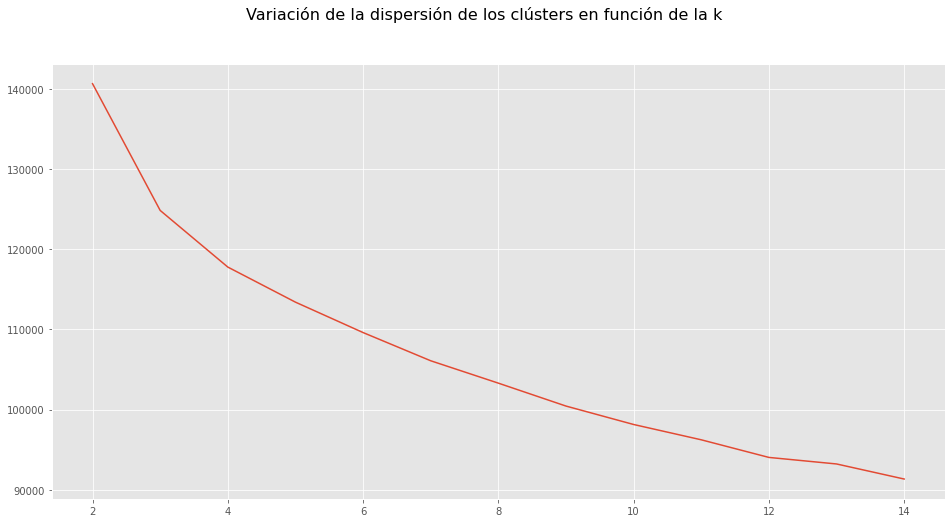

In [ ]:
if CALCULATE_ELBOW:
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

<a id = "segmentacion"></a>
# Segmentación de los clientes con la "k adecuada"
[Volver al índice](#table_of_contents)

Ahora que hemos determinado el número de centroides correcto podemos fittear nuestro pipeline con la ***k adecuada.***

Dado que vamos a realizar nuestra segmentación con KMeans y vamos a suministrarle las variables de nuestro interés, a veces, a KMeans se le conoce como **segmentación no supervisada pero guiada***. Guiada porque de alguna manera el data scientist le dice (lo guía) a que discrimine usando unas variables y no otras.

In [ ]:
 pipe = Pipeline(steps = [
     ("Imputer", KNNImputer()), 
     ("ArrayToDataFrame", ArrayToDataFrame(columns, index = index)),
     ("OutlierFilter", OutlierFilter(q = 0.99, col_to_filter = ['sales', 'mean_pvp', 'summer_sales_total %', 'weekend_sale_total %', 'christmas_sales_total %', 'exhibition_time', '2016_vs_2015', '2015_vs_2014','2014_vs_2013', 'mean_discount'])),
     ("StandardScaler", StandardScaler()),
     ("Clustering", KMeans(n_clusters = 4))
 ])

In [ ]:
 df_final.shape

(3049, 87)

In [ ]:
pipe.fit(df_final)

Pipeline(steps=[('Imputer', KNNImputer()),
                ('ArrayToDataFrame',
                 ArrayToDataFrame(columns=['sales_2011', 'sales_2012',
                                           'sales_2013', 'sales_2014',
                                           'sales_2015', 'sales_2016', 'sales',
                                           'mean_pvp', 'weekend_sale_total %',
                                           'summer_sales_total %',
                                           'christmas_sales_total %',
                                           '2016_vs_2015', '2015_vs_2014',
                                           '2014_vs_2013', '2013_vs_2012',
                                           '2012_vs_2011', 'precio_inicio',
                                           'exhib...
                                         'ACCESORIES_1_027', 'ACCESORIES_1_028',
                                         'ACCESORIES_1_029', 'ACCESORIES_1_030', ...])),
                ('OutlierFilter',

Una parte muy interesante de los pipelines es que la podemos filtrar (igual que una lista de python) y usar sólo parte de los pasos que tenemos implementados. 

Esto viene muy útil porque en nuestro caso, cuando vamos a hacer el predict (asignar a cada cliente su centroide), queremos imputar los nulos, crear las variables necesarias y estandarizar (paso 1, 3 y 5 del pipe), pero **no filtrar los outliers** (todos los clientes tienen que tener un grupo). Si hacemos el predict con todo el pipeline, algunos clientes no se van a asignar a ningún grupo.

In [ ]:
#  creamos un dataframe escalado con los pasos 1 - 2 y 4
X_processed = pipe[:2].transform(df_final)
X_scaled = pipe["StandardScaler"].transform(X_processed)
X_scaled.shape

(3049, 87)

In [ ]:
# hacemos el predict, en este caso tendremos para cada cliente su centroide/clúster.
labels = pipe["Clustering"].predict(X_scaled)

In [ ]:
pipe["Clustering"]

KMeans(n_clusters=4)

In [ ]:
 #le asignamos al DataFrame procesado los centroides.
 #SI LO HACEMOS AL ESCALADO LOS NÚMEROS PERDERAN SU SIGNIFICADO ESCALA Y SERÁN MÁS DÍFICILES DE INTERPRETAR.
X_processed["cluster"] = labels

In [ ]:
X_processed.shape

(3049, 88)

In [ ]:
# visualizamos nuestros grupos en base a las variables del modelo, para ver que tal han quedado.
selected_columns = ['sales', 'mean_pvp', 'summer_sales_total %', 'weekend_sale_total %', 'christmas_sales_total %', 'exhibition_time', '2016_vs_2015', '2015_vs_2014','2014_vs_2013', 'mean_discount']

# sns.pairplot(X_processed, vars = selected_columns, hue = 'cluster');

<a id = "ficha"></a>
# Ficha de los clientes
[Volver al índice](#table_of_contents)

El último paso, usa vez que tenemos hecha nuestra segmentación completa es crear una ***ficha resumen*** de cada grupo con las principales variables de negocio o con aquellas que no se han utilizado en la segmentación para hacer un seguimiento periódico de los grupos o para enviar como documento al resto de los departamentos de la empresa.

In [ ]:
ficha_df = pd.DataFrame()
ficha_df

""


In [ ]:
 for i, col in enumerate(['sales', 'mean_pvp', 'summer_sales_total %', 'weekend_sale_total %', 'christmas_sales_total %', 'exhibition_time', '2016_vs_2015', '2015_vs_2014','2014_vs_2013', 'mean_discount']):
     resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T[1:]
     ficha_df = ficha_df.append(resumen_data)

In [ ]:
 resumen_data

cluster                    0         1         2         3
mean_discount mean -0.005879 -0.006415 -0.003856 -0.007099
              std   0.069898  0.086441  0.075984  0.080758
              min  -0.224781 -0.652778 -0.249502 -0.361795
              25%  -0.025968 -0.019966 -0.036397 -0.038510
              50%   0.000000 -0.000232 -0.000947 -0.000499
              75%   0.028704  0.005247  0.018921  0.027179
              max   0.302433  1.539023  0.299235  0.317325

In [ ]:
# generamos nuestro multiindex
out_index = [
    "Ventas",
    "Precios",
    "Campañas",
    "Campañas",
    "Campañas",
    "Dias_en_venta",
    "Crecimiento",
    "Crecimiento",
    "Crecimiento",
    "Descuentos"
]

inner_index = [
    'sales', 
    'mean_pvp', 
    'summer_sales_total %', 
    'weekend_sale_total %', 
    'christmas_sales_total %', 
    'exhibition_time', 
    '2016_vs_2015', 
    '2015_vs_2014',
    '2014_vs_2013', 
    'mean_discount'
    ]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))
        
new_multi_index

[('Ventas', 'sales', 'Media'),
 ('Ventas', 'sales', 'Desviación'),
 ('Ventas', 'sales', 'Mínimo'),
 ('Ventas', 'sales', 'Perc. 25'),
 ('Ventas', 'sales', 'Perc. 50'),
 ('Ventas', 'sales', 'Perc. 75'),
 ('Ventas', 'sales', 'Máximo'),
 ('Precios', 'mean_pvp', 'Media'),
 ('Precios', 'mean_pvp', 'Desviación'),
 ('Precios', 'mean_pvp', 'Mínimo'),
 ('Precios', 'mean_pvp', 'Perc. 25'),
 ('Precios', 'mean_pvp', 'Perc. 50'),
 ('Precios', 'mean_pvp', 'Perc. 75'),
 ('Precios', 'mean_pvp', 'Máximo'),
 ('Campañas', 'summer_sales_total %', 'Media'),
 ('Campañas', 'summer_sales_total %', 'Desviación'),
 ('Campañas', 'summer_sales_total %', 'Mínimo'),
 ('Campañas', 'summer_sales_total %', 'Perc. 25'),
 ('Campañas', 'summer_sales_total %', 'Perc. 50'),
 ('Campañas', 'summer_sales_total %', 'Perc. 75'),
 ('Campañas', 'summer_sales_total %', 'Máximo'),
 ('Campañas', 'weekend_sale_total %', 'Media'),
 ('Campañas', 'weekend_sale_total %', 'Desviación'),
 ('Campañas', 'weekend_sale_total %', 'Mínimo'),
 ('C

In [ ]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [ ]:
 names = ["Grupo Indicadores", "Indicador", "Estadístico"]
 index_ficha = generate_multiindex(new_multi_index, names)
 ficha_df.set_index(index_ficha, inplace = True)

In [ ]:
 tamaño_clusters = X_processed.groupby("cluster").size().to_frame().T
 tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [ ]:
 ficha_df = tamaño_clusters.append(ficha_df)

In [ ]:
ficha_df

cluster                                                  0             1  \
Grupo Indicadores Indicador     Estadístico                                
General           Clúster       Tamaño          118.000000   1913.000000   
Ventas            sales         Media        392492.372542  22871.486932   
                                Desviación   236016.209477  13403.628125   
                                Mínimo        46127.000000    470.890000   
                                Perc. 25     280495.802500  12036.810000   
...                                                    ...           ...   
Descuentos        mean_discount Mínimo           -0.224781     -0.652778   
                                Perc. 25         -0.025968     -0.019966   
                                Perc. 50          0.000000     -0.000232   
                                Perc. 75          0.028704      0.005247   
                                Máximo            0.302433      1.539023   

cluster                                                  2             3  
Grupo Indicadores Indicador     Estadístico                               
General           Clúster       Tamaño          229.000000    789.000000  
Ventas            sales         Media        167252.481616  74149.102738  
                                Desviación    36816.910636  20975.498362  
                                Mínimo       106617.580000  13297.320000  
                                Perc. 25     138437.650000  57431.030000  
...                                                    ...           ...  
Descuentos        mean_discount Mínimo           -0.249502     -0.361795  
                                Perc. 25         -0.036397     -0.038510  
                                Perc. 50         -0.000947     -0.000499  
                                Perc. 75          0.018921      0.027179  
                                Máximo            0.299235      0.317325  

[71 rows x 4 columns]

In [ ]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

In [ ]:
ficha_df.to_excel("/content/drive/MyDrive/MASTER EN DATA SCIENCE/Capstone/data_dsmarket/GrupoRetail_1/Proceso Total/BBDD output/clusters_v1_7.xlsx")

In [ ]:
 X_processed['cluster']

ACCESORIES_1_001     1
ACCESORIES_1_002     1
ACCESORIES_1_003     1
ACCESORIES_1_004     2
ACCESORIES_1_005     1
                    ..
SUPERMARKET_3_823    1
SUPERMARKET_3_824    1
SUPERMARKET_3_825    3
SUPERMARKET_3_826    1
SUPERMARKET_3_827    1
Name: cluster, Length: 3049, dtype: int32

In [ ]:
 X_cluster = X_processed['cluster']

In [ ]:
 cluster_0 = X_processed[X_processed["cluster"] == 0]

In [ ]:
 cluster_1 = X_processed[X_processed["cluster"] == 1]

In [ ]:
 cluster_2 = X_processed[X_processed["cluster"] == 2]

In [ ]:
cluster_3 = X_processed[X_processed["cluster"] == 3]

In [ ]:
X_cluster.to_excel("/content/drive/MyDrive/MASTER EN DATA SCIENCE/Capstone/data_dsmarket/GrupoRetail_1/Proceso Total/BBDD output/bd_grupos_1_7.xlsx")

**FIN**